In [11]:
%%capture
!pip install transformers

In [12]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

from sklearn.utils import shuffle

/home/tfsservices/miniconda3/envs/nlp_test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
datapath = f'intents.csv'
# datapath = f'intents-without-none.csv'
df = pd.read_csv(datapath)
df.head()


,intent,utterance
0,Accept,$ 950k - $ 1.3 m is okay.
1,Accept,$1.2m is a pretty good offer.
2,Accept,$7k for the system including the pump works fo...
3,Accept,"€12,000 is good."
4,Accept,"1,550,000.00 usd is approved."


In [44]:
labels = ['Accept',
    'AskForEquipmentInstallation',
    'AskForInterest',
    'AskForPrice',
    'AskIfBuy',
    'AskIfHaveEquipment',
    'AskIfSell',
    'Decline',
    'DeclinePrice',
    'DeclineToBuy',
    'DeclineToSell',
    'DoNotHaveEquipment',
    'HaveDeinstalledEquipment',
    'HaveEquipment',
    'HaveInstalledEquipment',
    'None',
    'OfferPrice',
    'WantDeal',
    'WantToBuy',
    'WantToSell'
]

label2id = {k: v for v, k in enumerate(labels)}

# label_to_id = {
#     'Accept':0,
#     'AskForEquipmentInstallation':1,
#     'AskForInterest':2,
#     'AskForPrice':3,
#     'AskIfBuy':4,
#     'AskIfHaveEquipment':5,
#     'AskIfSell':6,
#     'Decline':7,
#     'DeclinePrice':8,
#     'DeclineToBuy':9,
#     'DeclineToSell':10,
#     'DoNotHaveEquipment':11,
#     'HaveDeinstalledEquipment':12,
#     'HaveEquipment':13,
#     'HaveInstalledEquipment':14,
#     'None':15,
#     'OfferPrice':16,
#     'WantDeal':17,
#     'WantToBuy':18,
#     'WantToSell':19
# }

id2label = {v: k for v, k in enumerate(labels)}



In [45]:
id2label

{0: 'Accept',
 1: 'AskForEquipmentInstallation',
 2: 'AskForInterest',
 3: 'AskForPrice',
 4: 'AskIfBuy',
 5: 'AskIfHaveEquipment',
 6: 'AskIfSell',
 7: 'Decline',
 8: 'DeclinePrice',
 9: 'DeclineToBuy',
 10: 'DeclineToSell',
 11: 'DoNotHaveEquipment',
 12: 'HaveDeinstalledEquipment',
 13: 'HaveEquipment',
 14: 'HaveInstalledEquipment',
 15: 'None',
 16: 'OfferPrice',
 17: 'WantDeal',
 18: 'WantToBuy',
 19: 'WantToSell'}

In [15]:
df = shuffle(df)
df.head()

,intent,utterance
3697,None,i would appreciate it.
1439,Decline,no longer needs it.
6267,WantToSell,i wanted to share this kla sp1 tbi with you.
2074,DoNotHaveEquipment,our manager does not have the model you require.
4681,None,they asked us for our response by 3 pm cst.


<Axes: xlabel='intent'>

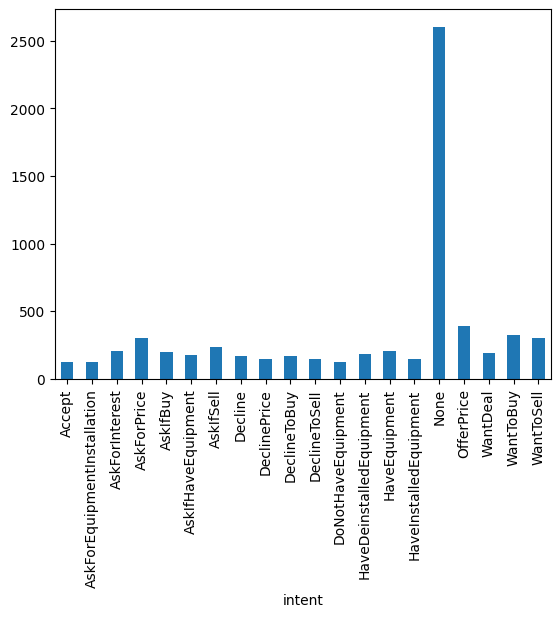

In [5]:
df.groupby(['intent']).size().plot.bar()

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# txt = "Do you have this equipment?"
# encoded1 = tokenizer(txt, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
# print(encoded1['input_ids'])


In [7]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [label2id[label] for label in df['intent']]
        self.texts = [
            tokenizer(text, 
                      padding='max_length', max_length = 512, truncation=True,
                      return_tensors="pt") for text in df['utterance']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [17]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        # self.linear = nn.Linear(768, 19)
        self.linear = nn.Linear(768, len(labels))
        self.relu = nn.ReLU()
        # self.softmax = nn.Softmax()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)
        # probs = self.softmax(final_layer)

        return final_layer

In [10]:
def train(model, train_data, val_data, learning_rate, epochs, batch_size):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')


In [11]:
def evaluate(model, test_data, batch_size:int):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [12]:
np.random.seed(112)
# df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df)), int(.9*len(df))])
# df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), [int(.98*len(df)), int(.99*len(df))])
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), [int(.98*len(df)), int(.99*len(df))])

print(len(df_train),len(df_val), len(df_test))

6342 65 65


In [13]:
EPOCHS = 7
LR = 1e-6
BATCH_SIZE = 2

model = BertClassifier()
train(model, df_train, df_val, LR, EPOCHS, BATCH_SIZE)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3171/3171 [02:57<00:00, 17.86it/s]


Epochs: 1 | Train Loss:  1.191 | Train Accuracy:  0.399 | Val Loss:  0.981 | Val Accuracy:  0.508


100%|██████████| 3171/3171 [02:57<00:00, 17.84it/s]


Epochs: 2 | Train Loss:  0.924 | Train Accuracy:  0.531 | Val Loss:  0.766 | Val Accuracy:  0.708


100%|██████████| 3171/3171 [02:57<00:00, 17.83it/s]


Epochs: 3 | Train Loss:  0.710 | Train Accuracy:  0.673 | Val Loss:  0.559 | Val Accuracy:  0.815


100%|██████████| 3171/3171 [02:57<00:00, 17.84it/s]


Epochs: 4 | Train Loss:  0.531 | Train Accuracy:  0.777 | Val Loss:  0.440 | Val Accuracy:  0.862


100%|██████████| 3171/3171 [02:57<00:00, 17.84it/s]


Epochs: 5 | Train Loss:  0.392 | Train Accuracy:  0.852 | Val Loss:  0.340 | Val Accuracy:  0.908


100%|██████████| 3171/3171 [02:56<00:00, 17.94it/s]


Epochs: 6 | Train Loss:  0.284 | Train Accuracy:  0.911 | Val Loss:  0.264 | Val Accuracy:  0.923


100%|██████████| 3171/3171 [02:56<00:00, 17.94it/s]


Epochs: 7 | Train Loss:  0.199 | Train Accuracy:  0.944 | Val Loss:  0.203 | Val Accuracy:  0.908


In [14]:
evaluate(model, df_test, BATCH_SIZE)

Test Accuracy:  0.800


In [18]:
import json

In [19]:
def evaluate_one_text(model, sentence):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    text = tokenizer(sentence, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")

    mask = text['attention_mask'].to(device)
    input_id = text['input_ids'].to(device)

    output = model(input_id, mask)

    with torch.no_grad():
        # print(output[0])

        probs = {id2label[i]:prob for i, prob in enumerate(torch.softmax(output[0], dim=-1).cpu().numpy())}
        sorted_probs = {k: v for k, v in sorted(probs.items(), key=lambda item: item[1], reverse=True)}
        print(sorted_probs)

        # label_id = output.argmax(dim=1)[0].item()
        # label = ids_to_labels[label_id]
        # print(label)

In [12]:
evaluate_one_text(model, "What is the price for this amat/applied materials unit.")

NameError: name 'model' is not defined

In [1]:
# path = './model-dict.dat'
# torch.save(model.state_dict(), path)

In [22]:
path = './model-dict.dat'
model1 = BertClassifier()
model1.load_state_dict(torch.load(path))
model1.eval()
evaluate_one_text(model1, "What is the price for this amat/applied materials unit.")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'AskForPrice': 0.825172, 'OfferPrice': 0.03205681, 'DeclinePrice': 0.021559052, 'WantToSell': 0.011354526, 'AskIfBuy': 0.01095999, 'None': 0.008494745, 'Accept': 0.008248007, 'AskForEquipmentInstallation': 0.0063196123, 'AskForInterest': 0.0063196123, 'AskIfHaveEquipment': 0.0063196123, 'AskIfSell': 0.0063196123, 'Decline': 0.0063196123, 'DeclineToBuy': 0.0063196123, 'DeclineToSell': 0.0063196123, 'DoNotHaveEquipment': 0.0063196123, 'HaveDeinstalledEquipment': 0.0063196123, 'HaveEquipment': 0.0063196123, 'HaveInstalledEquipment': 0.0063196123, 'WantDeal': 0.0063196123, 'WantToBuy': 0.0063196123}


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [19]:
# from typing import Dict


class IntentClassifierFull(nn.Module):

    def __init__(self, bertModel):

        super(IntentClassifierFull, self).__init__()

        self.label2id = label2id
        self.id2label = id2label
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
        self.model = bertModel
        self.softmax = nn.Softmax(dim=-1)

    # def forward(self, input: str) -> Dict[str, float]:
    def forward(self, input):

        with torch.no_grad():
            encoded = self.tokenizer(input, padding='max_length', max_length = 512, truncation=True, return_tensors="pt"),
            # print(encoded[0])
            output = self.model(encoded[0]['input_ids'], encoded[0]['attention_mask'])
            # print(output)
            probs = self.softmax(output)

            # probs = {ids_to_labels[i]:prob for i, prob in enumerate(torch.softmax(output[0], dim=-1).cpu().numpy())}
            # sorted_probs = {k: v for k, v in sorted(probs.items(), key=lambda item: item[1], reverse=True)}
            # print(sorted_probs)

        # return sorted_probs
        return probs

In [65]:

class IntentClassifier(nn.Module):

    def __init__(self, bertModel):

        super(IntentClassifier, self).__init__()

        self.labels = labels
        self.label2id = label2id
        self.id2label = id2label
        self.model = bertModel
        self.softmax = nn.Softmax(dim=-1)

    # def forward(self, input: str) -> Dict[str, float]:
    def forward(self, input_ids, mask):

        with torch.no_grad():
            output = self.model(input_ids, mask)
            # print(output)
            probs = self.softmax(output)

            # probs = {ids_to_labels[i]:prob for i, prob in enumerate(torch.softmax(output[0], dim=-1).cpu().numpy())}
            # sorted_probs = {k: v for k, v in sorted(probs.items(), key=lambda item: item[1], reverse=True)}
            # print(sorted_probs)

        # return sorted_probs
        return probs

In [66]:
# from typing import Dict


# class IntentClassifier(nn.Module):

#     def __init__(self, bertModel):

#         super(IntentClassifier, self).__init__()

#         self.label2id = labels
#         self.id2label = ids_to_labels
#         self.model = bertModel
#         self.softmax = nn.Softmax(dim=-1)

#     # def forward(self, input: str) -> Dict[str, float]:
#     def forward(self, input_ids, mask) -> Dict[str, float]:

#         # with torch.no_grad():
#         output = self.model(input_ids, mask)

#         probs = self.softmax(output)

#         probs = {ids_to_labels[i]:prob for i, prob in enumerate(torch.softmax(output[0], dim=-1).cpu().detach().numpy())}
#         sorted_probs = {k: v for k, v in sorted(probs.items(), key=lambda item: item[1], reverse=True)}
#             # print(sorted_probs)

#         # return sorted_probs
#         return sorted_probs

In [67]:
model2 = IntentClassifier(model1.to('cpu')).to('cpu')
# model2.eval()

In [68]:
txt = "Do you have this equipment?"
encoded = tokenizer(txt, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
model2(encoded["input_ids"], encoded["attention_mask"])

tensor([[0.0104, 0.0534, 0.0131, 0.0104, 0.0174, 0.6832, 0.0216, 0.0104, 0.0104,
         0.0104, 0.0104, 0.0306, 0.0104, 0.0422, 0.0104, 0.0104, 0.0104, 0.0104,
         0.0136, 0.0104]])

In [77]:
# path = './intent_classifier.dat'
# torch.save(model2.state_dict(), path)

In [86]:
# data = {"text":"Do you have this equipment?"}
# print(data["text"])
# model2(data)

In [59]:
# string_data = "Do you have this equipment?"
# # arr = bytearray(string_data, 'utf-8').to(torch.uint8)
# # print(arr)

# arr = torch.tensor(bytearray(string_data, 'utf-8'), dtype=torch.int64)
# model2(arr)


# print(arr)

# print(arr.dtype)
# for a in arr:
#     print(a)
# np.array(string_data)

In [36]:
# model2("Do you have this equipment?")

In [43]:
# torch.as_tensor("Do you have this equipment?")

In [25]:
!pip install onnx
import onnx

In [45]:
# amap = {str(i): i for i in range(50)}
# n = onnx.helper.make_node(
#     'LabelEncoder',
#     inputs=['X'],
#     outputs=['Y'],
#     keys_strings=amap.keys(),
#     values_int64s=amap.values(), 
#     domain='ai.onnx.ml'
# )

# X = onnx.helper.make_tensor_value_info("X", onnx.TensorProto.STRING, [None])
# Y = onnx.helper.make_tensor_value_info("Y", onnx.TensorProto.INT64, [None])

# graph_def = onnx.helper.make_graph(
#     nodes=[n],
#     name="mapper",
#     inputs=[X],
#     outputs=[Y]
# )

In [46]:
# print(graph_def)
# model2.eval()

In [47]:
# model2.eval()

In [31]:

# input_names = ['input_ids', 'mask']
# output_names = ['probs']

# txt = "Do you have this equipment?"
# encoded = tokenizer(txt, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
# dummy_inputs = {'input_ids': encoded['input_ids'], 'mask': encoded['attention_mask']}

# model2.eval()

# torch.onnx.export(model2,                 
#                   args=dummy_inputs,
#                   input_names=input_names,
#                   output_names=output_names,
#                   f="intent_classifier.onnx",
#                   opset_version=10,          # the ONNX version to export the model to
#                   do_constant_folding=True  # whether to execute constant folding for optimization
#                 #   dynamic_axes={'input_ids' : {0 : 'batch_size'},    # variable length axes
#                 #                 'probs' : {0 : 'batch_size'}}
#                 #   export_params=True,
#                 #   verbose=True
# )

============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [58]:
onnxfile = "intent_classifier.onnx"
modified_onnxfile = "modified_model.onnx"

In [69]:
input_names = ['input_ids', 'mask']
output_names = ['probs']

txt = "Do you have this equipment?"
encoded = tokenizer(txt, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
dummy_inputs = {'input_ids': encoded['input_ids'], 'mask': encoded['attention_mask']}


model2.eval()

torch.onnx.export(model2,                 
                  args=dummy_inputs,
                  input_names=input_names,
                  output_names=output_names,
                  f=onnxfile,
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True  # whether to execute constant folding for optimization
                #   dynamic_axes={'input_ids' : {0 : 'batch_size'},    # variable length axes
                #                 'probs' : {0 : 'batch_size'}}
                #   export_params=True,
                #   verbose=True
)

============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [ ]:
# onnx_model = onnx.load(onnxfile)
# graph = onnx_model.graph

# pads = onnx.helper.make_tensor('avg_pads', onnx.TensorProto.INT64, [8], np.zeros(8, dtype=int))
# graph.initializer.append(pads)
# node = graph.node[584]
# new_node = onnx.helper.make_node(
#     'Pad',
#     name='__Pad_584_fixed',
#     inputs=['675', 'avg_pads'],
#     outputs=['676'],
#     mode='constant'
# )
# graph.node.remove(node)
# graph.node.insert(584, new_node)
# # Fix Equals (replace with Not)
# node = graph.node[322]
# new_node = onnx.helper.make_node(
#     'Not',
#     name='__Not__Equal_322',
#     inputs=['412'],
#     outputs=['414'],
# )
# graph.node.remove(node)
# graph.node.insert(322, new_node)

# onnx.checker.check_model(onnx_model)
# onnx.save(onnx_model, onnxfile)

In [35]:
onnx_model = onnx.load(onnxfile)
onnx.checker.check_model(onnx_model)

graph_def = onnx_model.graph

nodes = graph_def.node

for node in nodes:
        print(node.name)
        print(node.op_type)
        print(node.input)
        print(node.output)
        # # Modify batchnorm attributes.
        # if node.op_type == "BatchNormalization":
        #     print("Attributes before adding:")
        #     for attribute in node.attribute:
        #         print(attribute)
        #     # Add epislon for the BN nodes.
        #     epsilon_attribute = onnx.helper.make_attribute("epsilon", 1e-06)
        #     node.attribute.extend([epsilon_attribute])
        #     # node.attribute.pop() # Pop an attribute if necessary.
        #     print("Attributes after adding:")
        #     for attribute in node.attribute:
        #         print(attribute)


# # n1 = [n for n in graph.node if n.output == ['probs']][0]
# # print(n)

# output = graph.output

new_node = onnx.helper.make_node(
    'LabelEncoder',
    inputs=['probs'],
    outputs=['Y'],
    keys_strings=labels.keys(),
    values_int64s=labels.values()
)

# X = onnx.helper.make_tensor_value_info("X", onnx.TensorProto.STRING, [None])
# Y = onnx.helper.make_tensor_value_info("Y", onnx.TensorProto.INT64, [None])

# # idx = output.index
# # print(idx)

# # graph.node.remove(output)
# graph.node.append(new_node)
# # graph.node.index(idx, new_node)







# onnx.checker.check_model(onnx_model)
# onnx.save(onnx_model, modified_onnxfile)










# print(graph)

# pads = onnx.helper.make_tensor('avg_pads', onnx.TensorProto.INT64, [8], np.zeros(8, dtype=int))
# graph.initializer.append(pads)
# node = graph.node[584]
# new_node = onnx.helper.make_node(
#     'Pad',
#     name='__Pad_584_fixed',
#     inputs=['675', 'avg_pads'],
#     outputs=['676'],
#     mode='constant'
# )
# graph.node.remove(node)
# graph.node.insert(584, new_node)
# # Fix Equals (replace with Not)
# node = graph.node[322]
# new_node = onnx.helper.make_node(
#     'Not',
#     name='__Not__Equal_322',
#     inputs=['412'],
#     outputs=['414'],
# )
# graph.node.remove(node)
# graph.node.insert(322, new_node)

# onnx.checker.check_model(onnx_model)
# onnx.save(onnx_model, onnxfile)

/model/bert/Constant
Constant
[]
['/model/bert/Constant_output_0']
/model/bert/Constant_1
Constant
[]
['/model/bert/Constant_1_output_0']
/model/bert/Constant_2
Constant
[]
['/model/bert/Constant_2_output_0']
/model/bert/ConstantOfShape
ConstantOfShape
['/model/bert/Constant_2_output_0']
['/model/bert/ConstantOfShape_output_0']
/model/bert/Constant_3
Constant
[]
['/model/bert/Constant_3_output_0']
/model/bert/Mul
Mul
['/model/bert/ConstantOfShape_output_0', '/model/bert/Constant_3_output_0']
['/model/bert/Mul_output_0']
/model/bert/Equal
Equal
['/model/bert/Constant_1_output_0', '/model/bert/Mul_output_0']
['/model/bert/Equal_output_0']
/model/bert/Where
Where
['/model/bert/Equal_output_0', '/model/bert/ConstantOfShape_output_0', '/model/bert/Constant_1_output_0']
['/model/bert/Where_output_0']
/model/bert/Expand
Expand
['/model/bert/Constant_output_0', '/model/bert/Where_output_0']
['/model/bert/Expand_output_0']
/model/bert/Unsqueeze
Unsqueeze
['mask']
['/model/bert/Unsqueeze_output_

In [37]:
import onnx
import onnxruntime

# amap = {str(i): i for i in range(20)}
n = onnx.helper.make_node(
    'LabelEncoder',
    inputs=['X'],
    outputs=['Y'],
    keys_strings=labels.keys(),
    # values_int64s=labels.values(), 
    values_int64s=labels.values(), 
    domain='ai.onnx.ml'
)

X = onnx.helper.make_tensor_value_info("X", onnx.TensorProto.STRING, [None])
Y = onnx.helper.make_tensor_value_info("Y", onnx.TensorProto.INT64, [None])

graph_def = onnx.helper.make_graph(
    nodes=[n],
    name="mapper",
    inputs=[X],
    outputs=[Y]
)

modelX = onnx.helper.make_model(
    graph_def,
    opset_imports=[
        onnx.helper.make_opsetid('ai.onnx.ml', 2), 
        onnx.helper.make_opsetid('', 14)],
)

out_path = "modified_model.onnx"
onnx.checker.check_model(modelX)
onnx.save(modelX, out_path)

ort_session = onnxruntime.InferenceSession(out_path)
inp = np.array(["AskIfSell"])
ort_inputs = {ort_session.get_inputs()[0].name: inp}
print(ort_session.run(None, ort_inputs))

[array([6], dtype=int64)]


============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [3]:
import onnx
from onnx import numpy_helper
import torch
from torchvision import models

onnx_model = onnx.load(onnxfile)

graph = onnx_model.graph
# initalizers = dict()
# for init in graph.initializer:
#     initalizers[init.name] = numpy_helper.to_array(init)

print(graph.input)
print(graph.output)
# for name, p in model2.named_parameters():
#     p.data = (torch.from_numpy(initalizers[name])).data

[name: "input_ids"
type {
  tensor_type {
    elem_type: 7
    shape {
      dim {
        dim_value: 1
      }
      dim {
        dim_value: 512
      }
    }
  }
}
, name: "mask"
type {
  tensor_type {
    elem_type: 7
    shape {
      dim {
        dim_value: 1
      }
      dim {
        dim_value: 512
      }
    }
  }
}
]
[name: "sorted_probs"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_value: 1
      }
      dim {
        dim_value: 20
      }
    }
  }
}
]


In [33]:
graph.input

[]

In [81]:
!pip install onnxruntime
!pip install transformers[onnx]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.2/451.2 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3


In [82]:
!python -m transformers.onnx --model=distilbert-base-uncased onnx/

Framework not requested. Using torch to export to ONNX.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Using framework PyTorch: 2.0.0+cu117
/home/tfsservices/miniconda3/envs/nlp_test/lib/python3.10/site-packages/transformers/models/distilbert/modeling_distilbert.py:223: TracerWarning: torch.tensor results are regis

In [85]:
import onnxruntime
from transformers import AutoTokenizer
from onnxruntime import InferenceSession

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
session = InferenceSession("onnx/model.onnx")
# ONNX Runtime expects NumPy arrays as input
inputs = tokenizer("Using DistilBERT with ONNX Runtime!", return_tensors="np")
outputs = session.run(output_names=["last_hidden_state"], input_feed=dict(inputs))

In [81]:
# import torch.onnx

# # model_2_export = torch.jit.script(model2)
# # x = torch.as_tensor("Do you have this equipment?")


# torch.onnx.export(model2,                    # model being run
#                   x,                         # model input (or a tuple for multiple inputs)
#                   "intent_classifier.onnx",   # where to save the model (can be a file or file-like object)
#                   export_params=True,        # store the trained parameter weights inside the model file
#                   opset_version=10,          # the ONNX version to export the model to
#                   do_constant_folding=True,  # whether to execute constant folding for optimization
#                   input_names = ['text'],   # the model's input names
#                   output_names = ['intents'], # the model's output names
#                   dynamic_axes={'text' : {0 : 'batch_size'},    # variable length axes
#                                 'intents' : {0 : 'batch_size'}})

/home/tfsservices/miniconda3/envs/nlp_test/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:717: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  tensor = as_tensor(value)


============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



/tmp/ipykernel_2023482/1516756600.py:21: TracerWarning: Converting a tensor to a NumPy array might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  probs = {ids_to_labels[i]:prob for i, prob in enumerate(torch.softmax(output[0], dim=-1).cpu().numpy())}


RuntimeError: Only tuples, lists and Variables are supported as JIT inputs/outputs. Dictionaries and strings are also accepted, but their usage is not recommended. Here, received an input of unsupported type: numpy.float32

In [19]:
evaluate_one_text(model, "Do you have this equipment?")

{'AskIfHaveEquipment': 0.7155939, 'AskIfBuy': 0.035149023, 'AskForEquipmentInstallation': 0.033871528, 'AskForInterest': 0.026417904, 'DoNotHaveEquipment': 0.02605449, 'AskIfSell': 0.021407254, 'HaveEquipment': 0.013339684, 'Decline': 0.012962977, 'None': 0.012009604, 'HaveDeinstalledEquipment': 0.011084783, 'AskForPrice': 0.009670952, 'DeclinePrice': 0.00965968, 'Accept': 0.009097273, 'DeclineToBuy': 0.009097273, 'DeclineToSell': 0.009097273, 'HaveInstalledEquipment': 0.009097273, 'OfferPrice': 0.009097273, 'WantDeal': 0.009097273, 'WantToBuy': 0.009097273, 'WantToSell': 0.009097273}


In [20]:
evaluate_one_text(model, "I am going to buy it for my company.")

{'WantToBuy': 0.77064633, 'WantToSell': 0.046400234, 'WantDeal': 0.027831074, 'DeclineToBuy': 0.019905794, 'DeclinePrice': 0.013577436, 'HaveInstalledEquipment': 0.0113623245, 'Accept': 0.0094270315, 'AskIfBuy': 0.009304696, 'AskIfSell': 0.008376279, 'OfferPrice': 0.007767368, 'AskForEquipmentInstallation': 0.0075401287, 'AskForInterest': 0.0075401287, 'AskForPrice': 0.0075401287, 'AskIfHaveEquipment': 0.0075401287, 'Decline': 0.0075401287, 'DeclineToSell': 0.0075401287, 'DoNotHaveEquipment': 0.0075401287, 'HaveDeinstalledEquipment': 0.0075401287, 'HaveEquipment': 0.0075401287, 'None': 0.0075401287}


In [21]:
evaluate_one_text(model, "What is the whether today?")

{'None': 0.97736883, 'AskForInterest': 0.0034101568, 'AskForPrice': 0.0022474593, 'AskIfHaveEquipment': 0.0018970915, 'Accept': 0.0016547564, 'WantDeal': 0.0012490745, 'AskForEquipmentInstallation': 0.001088749, 'Decline': 0.0010231821, 'AskIfBuy': 0.00086614804, 'AskIfSell': 0.000835869, 'DeclinePrice': 0.000835869, 'DeclineToBuy': 0.000835869, 'DeclineToSell': 0.000835869, 'DoNotHaveEquipment': 0.000835869, 'HaveDeinstalledEquipment': 0.000835869, 'HaveEquipment': 0.000835869, 'HaveInstalledEquipment': 0.000835869, 'OfferPrice': 0.000835869, 'WantToBuy': 0.000835869, 'WantToSell': 0.000835869}


In [40]:
evaluate_one_text(model, "price?")

{'AskForPrice': 0.9126778, 'AskForInterest': 0.02042869, 'AskIfBuy': 0.011594796, 'AskIfSell': 0.0052341246, 'Accept': 0.005062612, 'None': 0.0044942964, 'AskIfHaveEquipment': 0.0038659936, 'WantDeal': 0.0031420202, 'OfferPrice': 0.002811082, 'AskForEquipmentInstallation': 0.0027898855, 'Decline': 0.0027898855, 'DeclinePrice': 0.0027898855, 'DeclineToBuy': 0.0027898855, 'DeclineToSell': 0.0027898855, 'DoNotHaveEquipment': 0.0027898855, 'HaveDeinstalledEquipment': 0.0027898855, 'HaveEquipment': 0.0027898855, 'HaveInstalledEquipment': 0.0027898855, 'WantToBuy': 0.0027898855, 'WantToSell': 0.0027898855}


In [24]:
evaluate_one_text(model, "good enough?")

{'None': 0.46456534, 'AskForInterest': 0.3589044, 'WantDeal': 0.02085898, 'Accept': 0.016223133, 'AskForPrice': 0.014868883, 'AskIfBuy': 0.014588483, 'AskForEquipmentInstallation': 0.011593876, 'AskIfHaveEquipment': 0.0115301665, 'HaveEquipment': 0.008184502, 'AskIfSell': 0.0075092996, 'WantToSell': 0.007505899, 'Decline': 0.0070741177, 'DeclinePrice': 0.0070741177, 'DeclineToBuy': 0.0070741177, 'DeclineToSell': 0.0070741177, 'DoNotHaveEquipment': 0.0070741177, 'HaveDeinstalledEquipment': 0.0070741177, 'HaveInstalledEquipment': 0.0070741177, 'OfferPrice': 0.0070741177, 'WantToBuy': 0.0070741177}


In [25]:
evaluate_one_text(model, "kla tencor?")

{'AskIfSell': 0.21709855, 'AskForEquipmentInstallation': 0.21300681, 'AskIfHaveEquipment': 0.13903241, 'AskForInterest': 0.101318724, 'AskIfBuy': 0.06915638, 'AskForPrice': 0.048866913, 'OfferPrice': 0.030460024, 'HaveDeinstalledEquipment': 0.021107292, 'WantToSell': 0.0165179, 'Accept': 0.013039547, 'Decline': 0.013039547, 'DeclinePrice': 0.013039547, 'DeclineToBuy': 0.013039547, 'DeclineToSell': 0.013039547, 'DoNotHaveEquipment': 0.013039547, 'HaveEquipment': 0.013039547, 'HaveInstalledEquipment': 0.013039547, 'None': 0.013039547, 'WantDeal': 0.013039547, 'WantToBuy': 0.013039547}


In [26]:
evaluate_one_text(model, "kla tencor.")

{'WantToSell': 0.3074497, 'HaveEquipment': 0.14781605, 'WantToBuy': 0.073141046, 'DeclineToSell': 0.058000557, 'OfferPrice': 0.04403818, 'DeclinePrice': 0.04151325, 'Accept': 0.035329748, 'AskIfSell': 0.03185199, 'DoNotHaveEquipment': 0.031572387, 'None': 0.03013954, 'HaveInstalledEquipment': 0.02894686, 'AskForEquipmentInstallation': 0.018911198, 'AskForInterest': 0.018911198, 'AskForPrice': 0.018911198, 'AskIfBuy': 0.018911198, 'AskIfHaveEquipment': 0.018911198, 'Decline': 0.018911198, 'DeclineToBuy': 0.018911198, 'HaveDeinstalledEquipment': 0.018911198, 'WantDeal': 0.018911198}


In [27]:
evaluate_one_text(model, "do it?")

{'None': 0.9052222, 'AskForInterest': 0.0313498, 'Decline': 0.006507385, 'AskForEquipmentInstallation': 0.0063748485, 'AskIfHaveEquipment': 0.0056049842, 'WantDeal': 0.005475396, 'AskForPrice': 0.004673873, 'DeclineToBuy': 0.0038081172, 'Accept': 0.0025819542, 'AskIfBuy': 0.0025819542, 'AskIfSell': 0.0025819542, 'DeclinePrice': 0.0025819542, 'DeclineToSell': 0.0025819542, 'DoNotHaveEquipment': 0.0025819542, 'HaveDeinstalledEquipment': 0.0025819542, 'HaveEquipment': 0.0025819542, 'HaveInstalledEquipment': 0.0025819542, 'OfferPrice': 0.0025819542, 'WantToBuy': 0.0025819542, 'WantToSell': 0.0025819542}


In [28]:
evaluate_one_text(model, "is it still deinstalled?")

{'AskForEquipmentInstallation': 0.7826641, 'AskIfSell': 0.03436578, 'AskIfHaveEquipment': 0.024888279, 'DeclineToSell': 0.014696896, 'AskIfBuy': 0.013911255, 'HaveDeinstalledEquipment': 0.013652937, 'AskForInterest': 0.00913006, 'OfferPrice': 0.009072743, 'HaveEquipment': 0.008787502, 'None': 0.008513548, 'Accept': 0.008031688, 'AskForPrice': 0.008031688, 'Decline': 0.008031688, 'DeclinePrice': 0.008031688, 'DeclineToBuy': 0.008031688, 'DoNotHaveEquipment': 0.008031688, 'HaveInstalledEquipment': 0.008031688, 'WantDeal': 0.008031688, 'WantToBuy': 0.008031688, 'WantToSell': 0.008031688}


In [29]:
evaluate_one_text(model, "we are going to remove this unit from production next week.")

{'HaveDeinstalledEquipment': 0.3117689, 'HaveInstalledEquipment': 0.09889904, 'HaveEquipment': 0.08805725, 'DeclineToSell': 0.0652029, 'WantToSell': 0.05262022, 'DeclineToBuy': 0.046810664, 'DoNotHaveEquipment': 0.038615946, 'WantToBuy': 0.029944621, 'OfferPrice': 0.02820212, 'None': 0.024586426, 'Accept': 0.0215292, 'AskForEquipmentInstallation': 0.0215292, 'AskForInterest': 0.0215292, 'AskForPrice': 0.0215292, 'AskIfBuy': 0.0215292, 'AskIfHaveEquipment': 0.0215292, 'AskIfSell': 0.0215292, 'Decline': 0.0215292, 'DeclinePrice': 0.0215292, 'WantDeal': 0.0215292}


In [30]:
evaluate_one_text(model, "next week.")

{'None': 0.9880149, 'WantDeal': 0.0016548098, 'Decline': 0.0015076428, 'Accept': 0.0013216882, 'AskForInterest': 0.0009711102, 'DeclineToBuy': 0.00086875685, 'DoNotHaveEquipment': 0.0006758194, 'AskIfHaveEquipment': 0.0004148142, 'AskForPrice': 0.00040727423, 'AskForEquipmentInstallation': 0.00037848423, 'AskIfBuy': 0.00037848423, 'AskIfSell': 0.00037848423, 'DeclinePrice': 0.00037848423, 'DeclineToSell': 0.00037848423, 'HaveDeinstalledEquipment': 0.00037848423, 'HaveEquipment': 0.00037848423, 'HaveInstalledEquipment': 0.00037848423, 'OfferPrice': 0.00037848423, 'WantToBuy': 0.00037848423, 'WantToSell': 0.00037848423}


In [31]:
evaluate_one_text(model, "we can offer $ 70,000 for the picosun ald in an effort to try to come to an agreement this week .")

{'OfferPrice': 0.8050674, 'DeclinePrice': 0.043331653, 'WantDeal': 0.026522988, 'Accept': 0.021000506, 'WantToBuy': 0.009999576, 'WantToSell': 0.009021949, 'AskIfSell': 0.0085871555, 'AskForPrice': 0.0067168144, 'AskForEquipmentInstallation': 0.006112825, 'Decline': 0.005915982, 'AskForInterest': 0.005772312, 'AskIfBuy': 0.005772312, 'AskIfHaveEquipment': 0.005772312, 'DeclineToBuy': 0.005772312, 'DeclineToSell': 0.005772312, 'DoNotHaveEquipment': 0.005772312, 'HaveDeinstalledEquipment': 0.005772312, 'HaveEquipment': 0.005772312, 'HaveInstalledEquipment': 0.005772312, 'None': 0.005772312}


In [32]:
evaluate_one_text(model, "$ 19k / ea is much beyond my budget even it is new .")

{'DeclinePrice': 0.458032, 'OfferPrice': 0.3456582, 'WantToBuy': 0.020721454, 'DeclineToBuy': 0.01794207, 'HaveDeinstalledEquipment': 0.012771096, 'Accept': 0.011869908, 'DoNotHaveEquipment': 0.01055394, 'AskForEquipmentInstallation': 0.00941933, 'AskForInterest': 0.00941933, 'AskForPrice': 0.00941933, 'AskIfBuy': 0.00941933, 'AskIfHaveEquipment': 0.00941933, 'AskIfSell': 0.00941933, 'Decline': 0.00941933, 'DeclineToSell': 0.00941933, 'HaveEquipment': 0.00941933, 'HaveInstalledEquipment': 0.00941933, 'None': 0.00941933, 'WantDeal': 0.00941933, 'WantToSell': 0.00941933}


In [33]:
evaluate_one_text(model, "my customer budget for candella candela cs20r is 125k based on working condition mike .")

{'OfferPrice': 0.8750039, 'DeclinePrice': 0.03894349, 'Accept': 0.008771657, 'AskForPrice': 0.006042685, 'DoNotHaveEquipment': 0.0058640083, 'HaveInstalledEquipment': 0.0057974737, 'AskIfHaveEquipment': 0.0050947145, 'DeclineToBuy': 0.004916713, 'AskIfSell': 0.0043785004, 'HaveEquipment': 0.0041912934, 'WantToBuy': 0.0041264826, 'AskForEquipmentInstallation': 0.0040965592, 'AskForInterest': 0.0040965592, 'AskIfBuy': 0.0040965592, 'Decline': 0.0040965592, 'DeclineToSell': 0.0040965592, 'HaveDeinstalledEquipment': 0.0040965592, 'None': 0.0040965592, 'WantDeal': 0.0040965592, 'WantToSell': 0.0040965592}


In [34]:
evaluate_one_text(model, "we have a dual turn with gantry loader already .")

{'HaveEquipment': 0.6787693, 'None': 0.06630386, 'WantToBuy': 0.055241153, 'HaveInstalledEquipment': 0.028903458, 'WantToSell': 0.017660655, 'DeclineToBuy': 0.015195864, 'AskIfHaveEquipment': 0.014255892, 'DoNotHaveEquipment': 0.013900739, 'Accept': 0.010701824, 'WantDeal': 0.0103576025, 'AskForEquipmentInstallation': 0.008870973, 'AskForInterest': 0.008870973, 'AskForPrice': 0.008870973, 'AskIfBuy': 0.008870973, 'AskIfSell': 0.008870973, 'Decline': 0.008870973, 'DeclinePrice': 0.008870973, 'DeclineToSell': 0.008870973, 'HaveDeinstalledEquipment': 0.008870973, 'OfferPrice': 0.008870973}


In [35]:
evaluate_one_text(model, "but it is still being used not heavily but still being used w / back side alignment .") 

{'None': 0.95788217, 'WantDeal': 0.0064416113, 'Accept': 0.0055891047, 'HaveEquipment': 0.0026963954, 'AskForInterest': 0.0021464126, 'HaveInstalledEquipment': 0.0021373157, 'WantToBuy': 0.0019657295, 'Decline': 0.0017855184, 'AskForPrice': 0.0016936002, 'AskForEquipmentInstallation': 0.0016056527, 'AskIfBuy': 0.0016056527, 'AskIfHaveEquipment': 0.0016056527, 'AskIfSell': 0.0016056527, 'DeclinePrice': 0.0016056527, 'DeclineToBuy': 0.0016056527, 'DeclineToSell': 0.0016056527, 'DoNotHaveEquipment': 0.0016056527, 'HaveDeinstalledEquipment': 0.0016056527, 'OfferPrice': 0.0016056527, 'WantToSell': 0.0016056527}


In [36]:
evaluate_one_text(model, "We do not have approval to purchase anything yet")

{'DeclineToBuy': 0.39440435, 'WantToBuy': 0.09077857, 'DoNotHaveEquipment': 0.07007594, 'DeclineToSell': 0.052167118, 'Accept': 0.046616547, 'WantToSell': 0.04427364, 'AskIfSell': 0.04102678, 'DeclinePrice': 0.033389885, 'AskForEquipmentInstallation': 0.018938933, 'AskForInterest': 0.018938933, 'AskForPrice': 0.018938933, 'AskIfBuy': 0.018938933, 'AskIfHaveEquipment': 0.018938933, 'Decline': 0.018938933, 'HaveDeinstalledEquipment': 0.018938933, 'HaveEquipment': 0.018938933, 'HaveInstalledEquipment': 0.018938933, 'None': 0.018938933, 'OfferPrice': 0.018938933, 'WantDeal': 0.018938933}


In [37]:
evaluate_one_text(model, "who needs this equipment")

{'AskIfBuy': 0.40539405, 'WantToBuy': 0.15079449, 'AskIfHaveEquipment': 0.056698907, 'OfferPrice': 0.048500527, 'DeclineToBuy': 0.033242956, 'DeclinePrice': 0.027137954, 'HaveInstalledEquipment': 0.022355612, 'AskIfSell': 0.021021193, 'DeclineToSell': 0.020554036, 'HaveEquipment': 0.020016804, 'AskForEquipmentInstallation': 0.01991136, 'HaveDeinstalledEquipment': 0.01963216, 'Accept': 0.019342504, 'AskForInterest': 0.019342504, 'AskForPrice': 0.019342504, 'Decline': 0.019342504, 'DoNotHaveEquipment': 0.019342504, 'None': 0.019342504, 'WantDeal': 0.019342504, 'WantToSell': 0.019342504}


In [38]:
evaluate_one_text(model, "pls help me to find FEI FIB ,200,450") ## not correct

{'AskForPrice': 0.73943543, 'OfferPrice': 0.04992528, 'Accept': 0.030277442, 'DeclinePrice': 0.026345072, 'DoNotHaveEquipment': 0.017538743, 'None': 0.015950209, 'HaveEquipment': 0.013294258, 'AskIfHaveEquipment': 0.0106658945, 'Decline': 0.009230645, 'HaveInstalledEquipment': 0.009075862, 'AskIfSell': 0.0085241785, 'AskForEquipmentInstallation': 0.0077485545, 'AskForInterest': 0.0077485545, 'AskIfBuy': 0.0077485545, 'DeclineToBuy': 0.0077485545, 'DeclineToSell': 0.0077485545, 'HaveDeinstalledEquipment': 0.0077485545, 'WantDeal': 0.0077485545, 'WantToBuy': 0.0077485545, 'WantToSell': 0.0077485545}


In [39]:
evaluate_one_text(model, "Sorry we are buying not selling.")

{'DeclineToSell': 0.57138395, 'WantToSell': 0.10745828, 'DeclinePrice': 0.038377095, 'DeclineToBuy': 0.037403964, 'WantToBuy': 0.03374374, 'DoNotHaveEquipment': 0.027715765, 'HaveDeinstalledEquipment': 0.02268651, 'AskIfSell': 0.019911686, 'Decline': 0.013121919, 'Accept': 0.011654278, 'AskForEquipmentInstallation': 0.011654278, 'AskForInterest': 0.011654278, 'AskForPrice': 0.011654278, 'AskIfBuy': 0.011654278, 'AskIfHaveEquipment': 0.011654278, 'HaveEquipment': 0.011654278, 'HaveInstalledEquipment': 0.011654278, 'None': 0.011654278, 'OfferPrice': 0.011654278, 'WantDeal': 0.011654278}
